In [63]:
%matplotlib inline
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import skimage.io

In [64]:
def show(images) :
    if type(images) is np.ndarray:
        images = [images]
    l = len(images)
    fig = plt.figure()
    fig.set_size_inches(20,20)
    for i,image in enumerate(images):
        fig.add_subplot(1, l, i+1)
        if len(image.shape) == 3:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='gray')
          
    plt.show()


In [65]:
# returns frame number n from clip
def get_frame_number(clip, n) :
    frame = clip.get_frame(float(n)/clip.fps)
    return frame

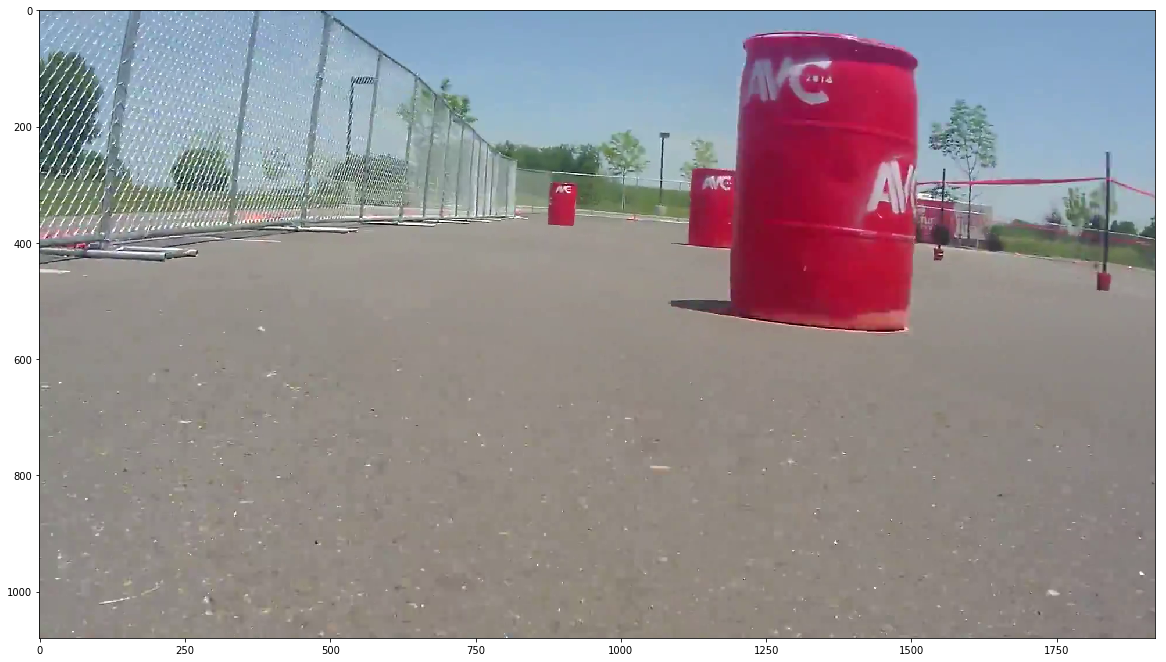

In [66]:
#im = cv2.imread('input/red_barrels_3.png')
clip = VideoFileClip('videos/video2.mp4')
im = clip.get_frame(21.0)
show(im)

In [67]:
cv2.imwrite('input/red_barrels4.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [68]:
def split_up(min,max,ticks):
    return [int(min + (max-min) * i / float(ticks)) for i in range(ticks+1)]

In [69]:
def draw_vanishing_lines(im, vanishing_point_xy):
    im_h, im_w, _ = im.shape
    radius = 10
    thickness = 3

    color = (50,50,255,100)

    im = cv2.circle(im,vanishing_point_xy,radius,color)

    for x in split_up(0-5000,im_w+5000,ticks=30):
      cv2.line(im, (x,im_h), vanishing_point_xy, color)


In [70]:
r,g,b = cv2.split(im)
#show([r>100])
#show([r/b])
#show(r<100)
#show(np.zeros_like(r))
#show(r/b>3)
#show(r/g>6)
#show(r>100)
#x = (r/b > 3) * (r/g>6) * (r>100)
#show(x)


In [71]:
r/b>3*255

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [72]:
# returns a binary mask where everything red in im is 1 and everything else is 0
def get_red_mask(im):

    r,g,b = cv2.split(im);
    # lower mask (0-10)
    #lower_red = np.array([50,0,0])
    #upper_red = np.array([255,75,100])
    #im_mask = cv2.inRange(im, lower_red, upper_red)
    im_mask = (r/b > 2) * (r/g>2) * (r>100)
    return np.array(im_mask,dtype=np.uint8)

# returns a binary mask where everything that is likely to be a barrel is set to 1
def get_barrel_mask(im):
    im_mask = get_red_mask(im)
    kernel = np.ones((11,3),np.uint8)
    kernel_vert = np.ones((11,1), np.uint8)
    
    center = (1,5)
    center_vert = (0,5)
    # get rid of small pieces of red
    im_mask = cv2.erode(im_mask, kernel, anchor=center, borderType=cv2.BORDER_CONSTANT, borderValue = 0)
    im_mask =cv2.dilate(im_mask, kernel, anchor=center, borderType=cv2.BORDER_CONSTANT, borderValue = 0)
    
    # connect vertically, this helps remove the white writing in the barrels
    im_mask =cv2.dilate(im_mask, kernel_vert, anchor=center_vert, iterations=6, borderType=cv2.BORDER_CONSTANT, borderValue = 0)
    im_mask = cv2.erode(im_mask, kernel_vert, anchor=center_vert, iterations=6, borderType=cv2.BORDER_CONSTANT, borderValue = 0)

    return im_mask


In [73]:
# returns a copy of im masked by mask
def mask_image(im, mask):
    im_out = im.copy()
    im_out[np.where(mask==0)] = 0
    return im_out


In [74]:
def find_red(im):
    return mask_image(im, get_red_mask(im))

In [75]:
def find_red_barrels(im):
    return mask_image(im, get_barrel_mask(im))

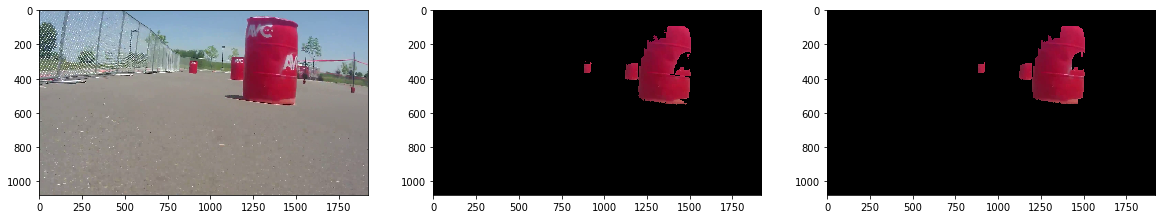

In [76]:
im_red = find_red(im)
im_barrels = find_red_barrels(im)
show([im, im_red, im_barrels])


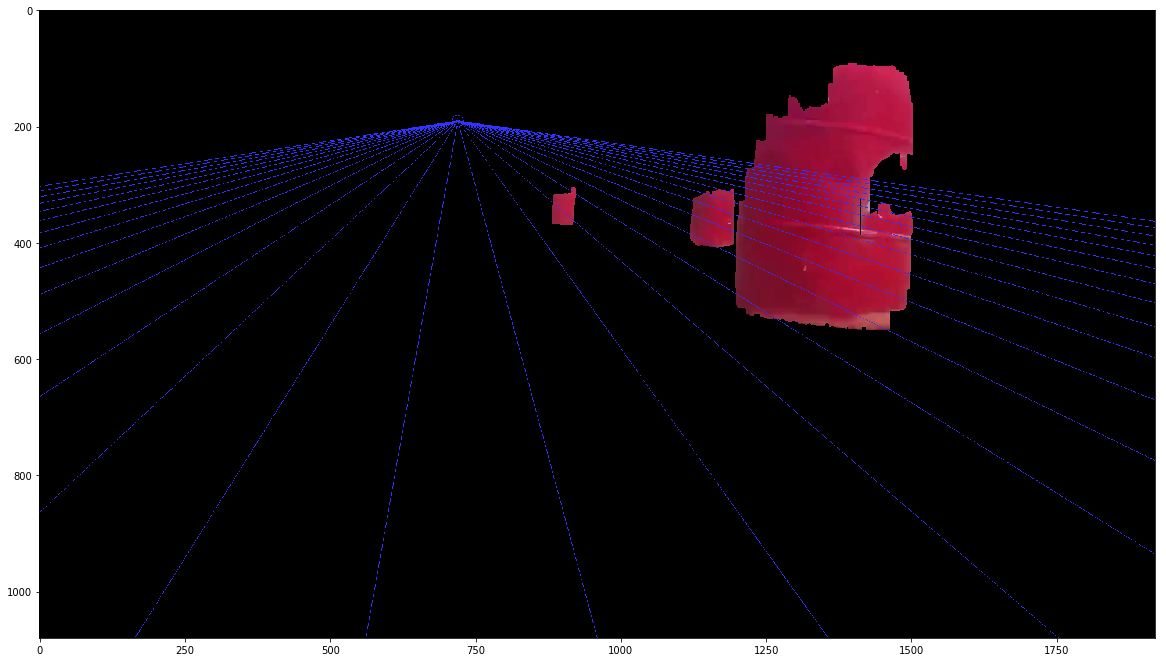

In [77]:
vanishing_point_xy = (720,190) 
horizon = vanishing_point_xy[1]
draw_vanishing_lines(im_barrels, vanishing_point_xy)
show([im_barrels])

In [78]:
# top of barrel should be above horizon, bottom of barrel should be below horizon
# middle of barrel should be above horizon

In [79]:
def describe_keypoints(keypoints):
    for k in keypoints:
        print('angle', k.angle)
        print('class_id',k.class_id)
        print('octave', k.octave)
        print('pt',k.pt)
        print('response',k.response)
        print('size',k.size)
        print()

# describe_keypoints(keypoints)

In [80]:
def circularity(contour):
    perimeter = cv2.arcLength(contour, True)
    return 4 * math.pi * cv2.contourArea(contour) / (perimeter * perimeter)


In [81]:
def centroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)
    

In [82]:
# draws barrel information on im 
def annotate_red_barrels(im):
    im_mask = get_barrel_mask(im)
    im_draw = im.copy()
    # see http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
    im_,contours,hierarchy = cv2.findContours(im_mask,cv2.RETR_TREE ,2)

    for contour, i in zip(contours,range(len(contours))):
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(im_draw, (x,y), (x+w, y+h),(0,255,0),2)
        hull = cv2.convexHull(contour,contour)
        cv2.drawContours(im_draw,[hull],0,(0,0,255),2)
        #area = cv2.contourArea(contour)
        #if area < 20*20:
        #    continue
        #if(len(contour)>=5): 
        #    e = cv2.fitEllipse(contour)
        #    cv2.ellipse(im_draw, e, (255,255,155))
    return im_draw

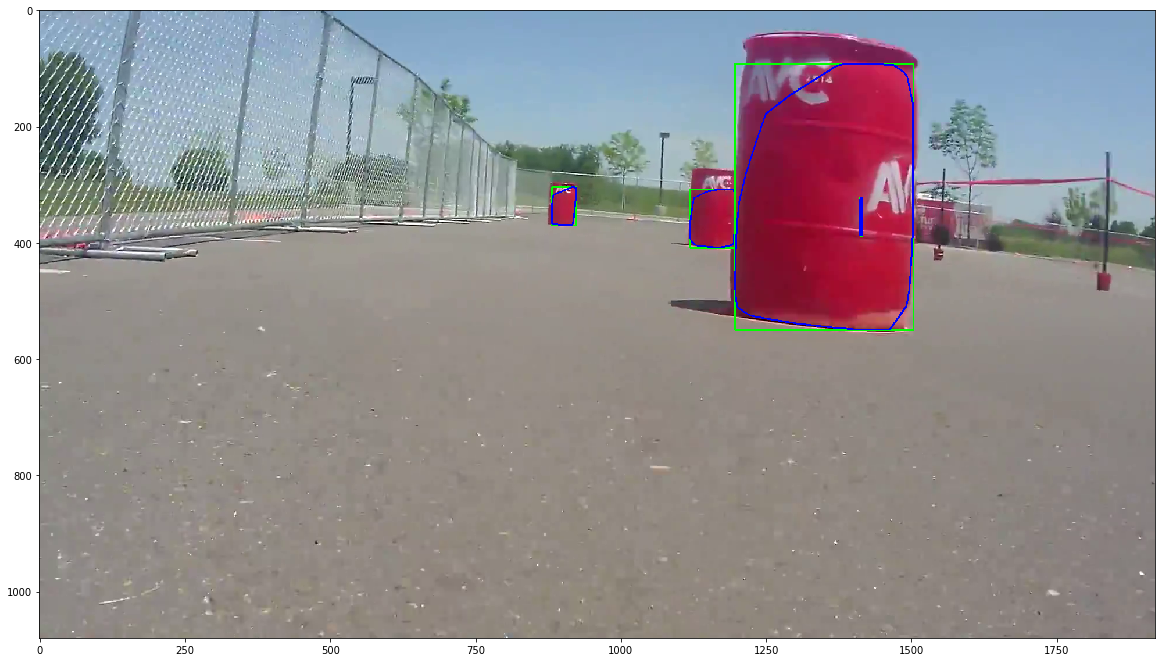

In [83]:
show(annotate_red_barrels(im))

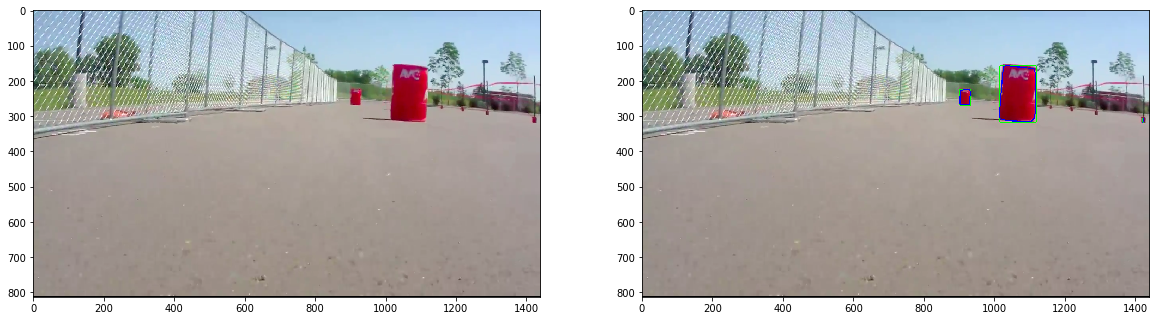

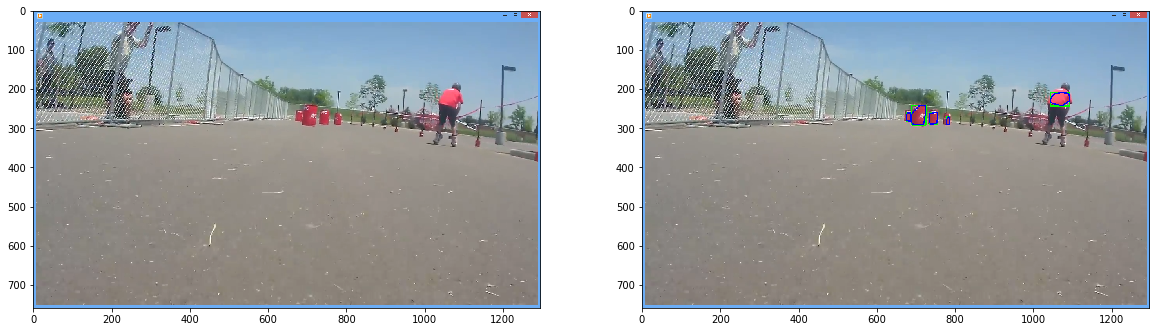

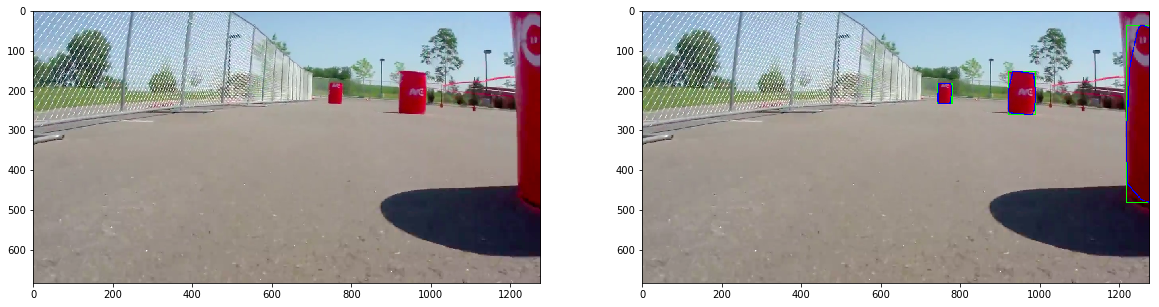

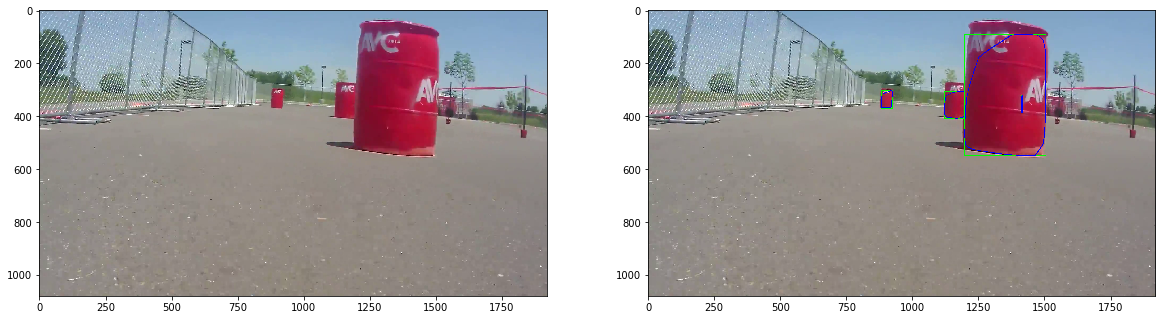

In [84]:
import glob
test_image_paths = glob.glob('input/red_barrels*.png')
for test_image_path in test_image_paths:
    im = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    im_annotated = annotate_red_barrels(im)
    show([im,im_annotated])
    
    

In [87]:
input_path='videos/video1.mp4'
output_path = 'output/video1.mp4'
clip1 = VideoFileClip(input_path)
clip = clip1.fl_image(annotate_red_barrels)
%time clip.write_videofile(output_path, audio=False, fps=5)

[MoviePy] >>>> Building video output/video1.mp4
[MoviePy] Writing video output/video1.mp4


100%|██████████| 329/329 [00:16<00:00, 19.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/video1.mp4 

CPU times: user 54.6 s, sys: 988 ms, total: 55.5 s
Wall time: 17.5 s


In [88]:
vinput_path='videos/video2.mp4'
output_path = 'output/video2.mp4'
clip1 = VideoFileClip(input_path)
clip = clip1.fl_image(annotate_red_barrels)
%time clip.write_videofile(output_path, audio=False, fps=5)

[MoviePy] >>>> Building video output/video2.mp4
[MoviePy] Writing video output/video2.mp4


100%|██████████| 329/329 [00:16<00:00, 20.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/video2.mp4 

CPU times: user 54 s, sys: 836 ms, total: 54.8 s
Wall time: 16.8 s
